# Lasso via ADMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as spla

## Utility Functions

In [14]:
def soft_thresh(x, threshold):
    """Soft threshold function

    Inputs:
    x : variable
    threshold: scalar
    """

    return np.sign(x) * np.maximum(np.absolute(x) - threshold, np.zeros(np.shape(x)))

def calc_obj(X,y,beta, z, lam):
    """Normalized MSE + l_1 regularization for ADMM (two decision vectors!)""" 

    return (1 / np.shape(X)[0]) * (np.linalg.norm(y - np.dot(X, beta)))**2 + lam * np.sum(np.abs(z))

## ADMM function

The objective function approaches the optimal value in standard ADMM. There is no guarantee for the convergence of the decision variables, however. The convergence criterion is chosen accordingly.

In [33]:
def admm(X, y, beta, rho = 1, lam = 0.0001, tol = 1e-2):
    """
    Solve lasso with ADMM. Following the formulation of Boyd 2011 review paper.
    
    Inputs:
    X: feature matrix
    y: labels
    beta: variables
    g: Parameter of lasso
    tol: tolerance
    rho: ADMM parameter
    """

    last_obj = float('inf')
    obj_change = float('inf')
    costs = []

    # cache some matrices
    XTX = np.dot(X.T, X)
    inv_mtx = XTX + rho * np.identity(np.shape(X)[1])
    lu_mtx = spla.lu_factor(inv_mtx)
    
    XTy = np.dot(X.T, y)

    costs = []
    z = np.copy(beta)
    u = np.zeros(beta.shape) #initialized to zero
    
    iter_count = 0
    
    while obj_change > tol:
        
        iter_count += 1
        
        # solve for beta (x in original formulation)
        right_mtx = XTy + rho * (z - u)
        beta = spla.lu_solve(lu_mtx, right_mtx)
        
        # update z and u
        z = soft_thresh(beta + u, lam/rho)
        u = u + beta - z

        current_obj = calc_obj(X,y,beta, z, lam)
        obj_change = abs(current_obj - last_obj)
        last_obj = current_obj
        costs.append(current_obj)

    return beta, costs, iter_count

## Read data and perform optimization

In [24]:
X = pd.read_csv('diabetesX.csv')
y = pd.read_csv('diabetesY.csv',header=None)

# Add a column of 0.01's for the intercept. Chose 0.01 to be in a similar scale with other features
X['ones'] = 0.01* np.ones((X.shape[0],1))

X = X.values
y = y.values

#Randomly initialize beta
beta = np.random.rand(X.shape[1],1) 

# Optimize
rhos = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]
all_costs = []
iter_counts = []

for r in rhos:
    beta0 = beta.copy()
    beta0, costs, iter_count = admm(X,y,beta0, rho = r)
    all_costs.append(costs)
    iter_counts.append(iter_count)

## Plot

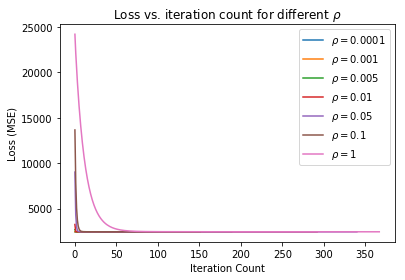

In [30]:
plt.figure()
for idx, r in enumerate(rhos[:-1]):
    plt.plot(all_costs[idx], label = r'$\rho = $' + str(r))
    
plt.ylabel('Loss (MSE)')
#plt.yscale('log')
plt.xlabel('Iteration Count')
plt.title(r'Loss vs. iteration count for different $\rho$')
plt.legend()
plt.show()



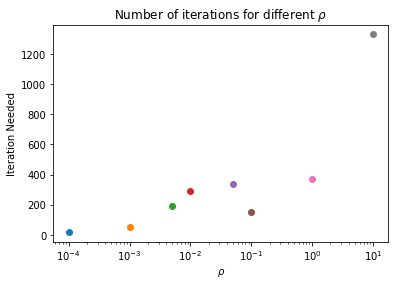

In [34]:
plt.figure()
for idx, r in enumerate(rhos):
    plt.plot(r,iter_counts[idx], 'o')
    
plt.ylabel('Iteration Needed')
plt.xlabel(r'$\rho$')
plt.xscale('log')
plt.title(r'Number of iterations for different $\rho$')
plt.legend()
plt.show()

## Results

### Minimum MSE

The first figure shows how the loss function decreases as we perform more iterations. The minimum in-sample MSE we get from proximal gradient descent is 2435. This is very close to the optimal in-sample MSE obtained by the scikit-learn package (described in detail in [this notebook](https://github.com/bowenhua/SDS_385/blob/master/5_sparsity/lasso_CV.ipynb)), as well as the optimal in-sample MSE obtained by proximal gradient method (described in detail in [this notebook](https://github.com/bowenhua/SDS_385/blob/master/6_proximal_gradient/Proximal%20gradient%20method.ipynb)).

We also note that the convergence of ADMM seems to be faster than proximal gradient method for this problem.

### Choosing $\rho$

Under mild assumptions, we can show that the objective function converges to minimum for all $\rho >0$. if $\rho = 0$, then we are doing some kind of dual decomposition. 

How to choose the optimal $\rho$ is not obvious to me. I tried different values (see the second figure.)

[This paper](https://arxiv.org/abs/1306.2454) focuses on optimal parameter selection for ADMM.